In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

# Tutorial: Custom priors

In this tutorial, we will explore the benefits of using a custom prior in solving the Branched Optimal Transport (BOT) problem. The BOT problem involves finding the optimal transportation plan between a set of source and sink nodes, considering the branching structure of the network. Initially, we will employ an _uninformed prior_, represented by a _star graph_, to solve the BOT problem and assess its execution times and performance. Subsequently, we will introduce the concept of **Minimum Spanning Trees (MSTs)** as a more informed prior for a MST-like problem with a low value of $\alpha$.

### Defining auxiliary function
To get started, we will import the necessary modules and define the main auxiliary function `optimize_topology` that will take care of performing both the geometry and the topology optimization; for more info about this check `tutorial-1-solving-branched-optimal-transport-problems.ipynb`):

In [19]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import time
#-------------------------------------------
import MST_prior as mst
import utils
import iterative_geometry_solver as igs
import greedy_topology_optimization as gto 

In [20]:
def optimize_topology(topo):
    # Geometry optimization
    cost, coords_iter = igs.iterative_geometry_solver(topo,
                                                      supply_arr, 
                                                      demand_arr, 
                                                      coords_sources, 
                                                      coords_sinks, 
                                                      al,
                                                      relative_improvement_threshold=1e-6,
                                                      min_iterations=-1,
                                                      max_iterations=1000,
                                                      plot=False,
                                                      title="",
                                                      fov=None,
                                                      save=False,
                                                      save_name="img",
                                                      figsize=(4,4))
    
    # Topology optimization
    T = 0
    keep_going = True
    iteration = 0
    sample_edge_list = list(topo.edges())

    time0 = time.time()
    while keep_going and iteration < 60000:
        iteration += 1
        topo, sample_edge_list, cost, coords_iter, accepted = gto.monte_carlo_step(topo, sample_edge_list, cost,
                                                                                   coords_iter, bot_problem_dict,
                                                                                   temperature=T)
        # check if converged
        if len(sample_edge_list) == 0:
            # this means that we have stuck with one topology for an entire run through.
            keep_going = False

    execution_time = np.round(time.time() - time0, 2)
    print(f"Final result, after {iteration} iterations and {execution_time} seconds.")
    
    # Visualization
    
    utils.visualise_BOT_solution(topo, 
                       coords_iter, 
                       supply_arr, 
                       demand_arr, 
                       title="", fov=None, save=False, save_name="img",
                       figsize = (4,4))
    
    return topo, iteration, execution_time

### Defining Problem Parameters
Next, the code defines the problem parameters. The snippet contains the following lines:

In [4]:
seed=138
np.random.seed(seed)
num_terminals = 20

### Generating Random Problem
The code generates a random problem using the `generate_random_bot_problem` function. It sets the number of sources and sinks randomly and retrieves the problem dictionary containing coordinates, supply, and demand arrays.

In [5]:
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = utils.generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                                       max_length=1.)

We redefine the parameter $\alpha$ to make it be **more similar to the MST regime**.

In [6]:
bot_problem_dict['al'] = 0.1

Let's now extract the information defining the problem into a set of variables.

In [7]:
al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

Notice that in this case, the number of sources and sinks is:

In [8]:
print(len(coords_sources))
print(len(coords_sinks))

10
10


### Uninformed prior: Star graph
To begin, we will establish an initial topology to work with. In this particular case, we will create a star graph as our starting point.

In [9]:
# init star graph:
star = nx.Graph()
for node in range(len(supply_arr) + len(demand_arr)):
    star.add_edge(-1, node)

Notice that this graph has the following properties:

In [10]:
# The number of nodes
num_nodes = star.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = star.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 21
Number of edges: 20


And it looks like this:

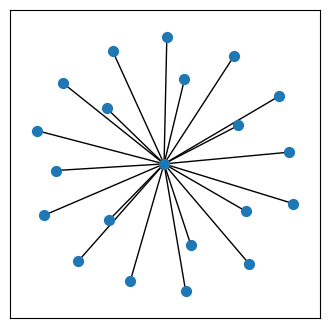

In [11]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(star, seed = 1)
nx.draw_networkx(star, pos = pos, node_size = 50, with_labels = False)

This graph can be considered as our initial approximation of the solution to the problem of connecting the given sources and sinks.

### Solving the problem
We finally solve the problem using our auxiliary function. We stored the execution time, among other things. The next cell also gets us a plot of the solution.

Final result, after 176 iterations and 1.88 seconds.


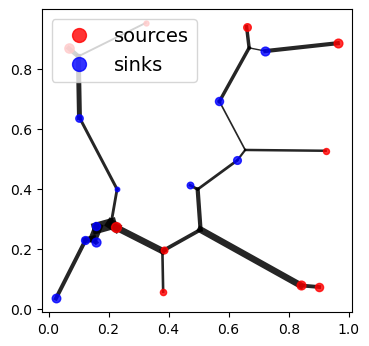

In [12]:
star, iteration_star, execution_star = optimize_topology(star)

## Custom prior: Minimum Spanning Tree
We use the module `MST_prior_topology` to build the `mst` using the coordinates of the sources and sinks.

A **Minimum Spanning Tree (MST)** is a tree that connects all the vertices of a given graph with the minimum possible total edge weight. In an MST, every vertex is included, and there are no cycles or redundant edges. 

In [13]:
# init star graph:
mst_graph = mst.MST_prior_topology(coords_sources, coords_sinks)

Notice that this graph has the following properties:

In [14]:
# The number of nodes
num_nodes = mst_graph.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = mst_graph.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 34
Number of edges: 33


And it looks like this:

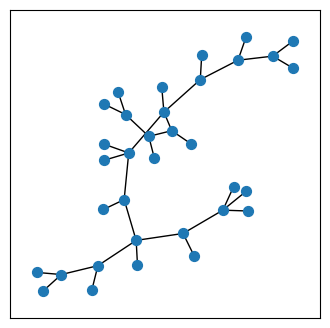

In [15]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(mst_graph, seed = 1)
nx.draw_networkx(mst_graph, pos = pos, node_size = 50, with_labels = False)

### Solving the BOT problem with an informed MST prior

Finally, we solve the problem making use of this topology.

Final result, after 50 iterations and 0.34 seconds.


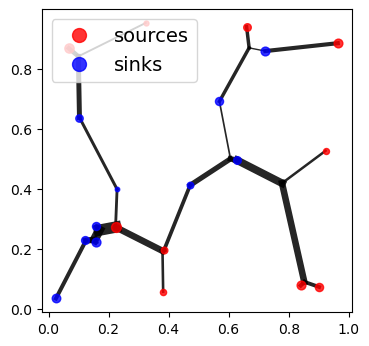

In [16]:
mst_graph, iteration_mst, execution_mst = optimize_topology(mst_graph)

We can see that the MST consistently yields the identical topology as the one observed in the initial case. But as can be observed in the next cell, the execution time of the algorithm gets extremely reduced (~5x). 

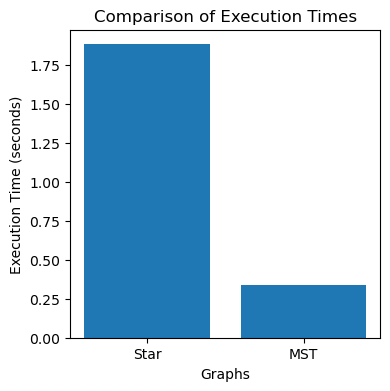

In [17]:
# Create a bar plot
fig = plt.figure(figsize=(4, 4))
execution_times = [execution_star, execution_mst]
labels = ['Star', 'MST']

plt.bar(labels, execution_times)
plt.xlabel('Graphs')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Times')
plt.show()

Congratulations! We have successfully solved a BOT problem with an **informed prior** to get faster and more accurate. 